# Experiments With SOM Networks
## Breast Cancer Wisconsin Dataset

Test different combinations of learning rates and sigma value (size of neighborhood).

All tests are going to use the gaussian neighborhood with a random seed of 5 to initialize the weights.

To show the results, the best resulting network will be choosen.

## Imports

In [1]:
from minisom import MiniSom
from sklearn import datasets
import itertools
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [2]:
# Model building

## Create the model reference using the choosen parameters
def create_model(size, input_dim, sigma=1.0, learning_rate=1.0, nf="gaussian", random_seed=5):
    return MiniSom(size, size, input_dim, sigma=sigma, learning_rate=learning_rate, 
                   neighborhood_function=nf, random_seed=random_seed)

## Create multiple models based of a list of parameters (dicts)
## Returns a list of dicts containing the parameters and the model reference
def create_bundle_of_models(model_parameters):
    return [
        {**{"model": create_model(**model_parameter)}, **model_parameter}
        for model_parameter in model_parameters
    ]

## Creates all of the possible combinations of parameters between two lists
def create_permutations(list_of_data_1, list_of_data_2):
    return list(itertools.product(list_of_data_1, list_of_data_2))

## Creates a list of dicts containing the parameters desired, using the permutation function
def create_test_parameters(sigma_list, learning_rate_list):
    return [
        {"sigma": parameter[0], "learning_rate": parameter[1]}
        for parameter in create_permutations(sigma_list, learning_rate_list)
    ]

# Data manipulation

## Rescale the data between 0 and 1: Xr = X - X_min/(X_max - X_min)
def normalize_data(data):
    max_value = np.max(data)
    min_value = np.min(data)
    return (data - min_value) / (max_value - min_value)

# Plots

## Plot the u-matrix with the target classes on each winner neuron
def plot_u_matrix(model):
    plt.figure(figsize=(10, 10))
    plt.pcolor(model['model'].distance_map().T, cmap='coolwarm')
    plt.colorbar()    

    markers = ['o', 'v', 's']
    colors = ['C2', 'C1', 'C3']
    for idx, data in enumerate(input_data):
        winner = model['model'].winner(data)
        plt.plot(winner[0]+.5, winner[1]+.5, markers[target[idx]], markerfacecolor='None',
                 markeredgecolor=colors[target[idx]], markersize=12, markeredgewidth=2)
    plt.axis([0, 30, 0, 30])
    plt.show()
    
def plot_hit_map(model):
    plt.figure(figsize=(10, 10))
    plt.pcolor(model['model'].activation_response(input_data), cmap='Reds')
    plt.colorbar() 

## The Dataset

In [3]:
breast_cancer = datasets.load_breast_cancer()

# Data already in desired format for the MiniSom library (numpy matrix)
# Contains the features on the "data" key and the target classifications on "target" key
print("Number of samples: %s" % (len(breast_cancer["data"])))
print(breast_cancer)

Number of samples: 569
{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,

In [4]:
# Splitting the data

# Normalized input
input_data = normalize_data(breast_cancer["data"])

# Target classes
target = breast_cancer["target"]

## Model parameters and building

In [5]:
sigma_list = [0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
learning_rate_list = [0.01, 0.1, 0.5, 1.0, 2.0]

# Fixed grid of 30x30
size = 30

# Fixed iteration number for all models
iterations = 10000

# Number of features, in this case, 4
input_dim = input_data.shape[1]

models = create_bundle_of_models(
    [
        {**parameters, **{"size": size, "input_dim": input_dim}}
        for parameters in create_test_parameters(sigma_list, learning_rate_list)
    ]
)

## Train the models and capture topographic and quantization errors (for ranking)

In [6]:
for model in models:
    # Training using random samples each iteration
    model["model"].train_batch(input_data, iterations)
    model["topographic_error"] = model["model"].topographic_error(input_data)
    model["quantization_error"] = model["model"].quantization_error(input_data)

## Ranking the best models

In [7]:
ranked_models = sorted(models, key = lambda x: (x["topographic_error"], x["quantization_error"]))
best_model = ranked_models[0]
ranked_models

[{'model': <minisom.MiniSom at 0x7f9abab11cc0>,
  'sigma': 2.0,
  'learning_rate': 0.01,
  'size': 30,
  'input_dim': 30,
  'topographic_error': 0.12478031634446397,
  'quantization_error': 0.013509566718669484},
 {'model': <minisom.MiniSom at 0x7f9abab11b70>,
  'sigma': 2.0,
  'learning_rate': 2.0,
  'size': 30,
  'input_dim': 30,
  'topographic_error': 0.15289982425307558,
  'quantization_error': 0.005066916326365658},
 {'model': <minisom.MiniSom at 0x7f9abab11fd0>,
  'sigma': 1.0,
  'learning_rate': 1.0,
  'size': 30,
  'input_dim': 30,
  'topographic_error': 0.16695957820738136,
  'quantization_error': 0.0030078979687073407},
 {'model': <minisom.MiniSom at 0x7f9aba86c7f0>,
  'sigma': 1.0,
  'learning_rate': 0.5,
  'size': 30,
  'input_dim': 30,
  'topographic_error': 0.17926186291739896,
  'quantization_error': 0.00443099698447032},
 {'model': <minisom.MiniSom at 0x7f9abab11c50>,
  'sigma': 2.0,
  'learning_rate': 0.1,
  'size': 30,
  'input_dim': 30,
  'topographic_error': 0.18277

## Data visualization

### U-Matrix

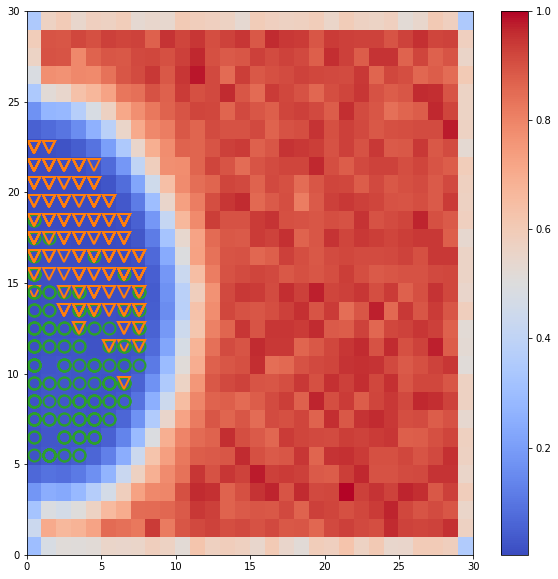

In [8]:
# Rank 1 model

plot_u_matrix(best_model)

### Heat Maps

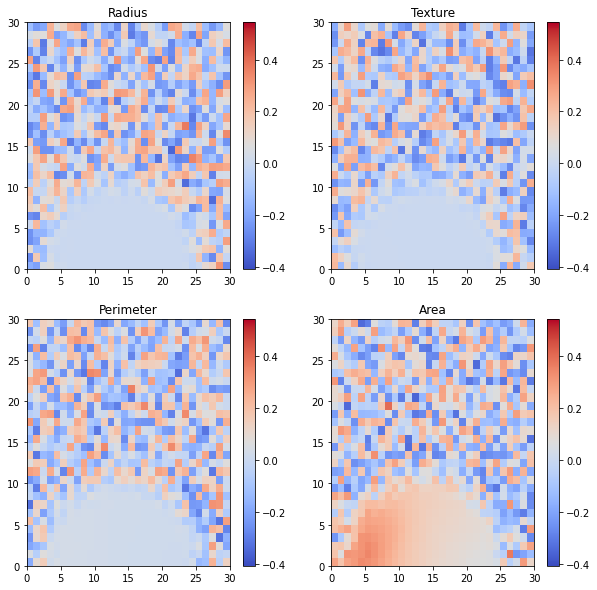

In [9]:
# Rank 1 model

def get_weights(weights, feature_idx):
    feature_weights = []
    for neuron in weights:
        data = []
        for weight in neuron:
            data.append(weight[feature_idx])
        feature_weights.append(list(data))

    return np.array(feature_weights)

def plot_heat_maps(data_1, data_2, data_3, data_4, min_weight, max_weight):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    cm = axs[0, 0].pcolor(data_1, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[0, 0].set_title('Radius')
    fig.colorbar(cm, ax=axs[0,0])

    cm = axs[0, 1].pcolor(data_2, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[0, 1].set_title('Texture')
    fig.colorbar(cm, ax=axs[0,1])

    cm = axs[1, 0].pcolor(data_3, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[1, 0].set_title('Perimeter')
    fig.colorbar(cm, ax=axs[1,0])

    cm = axs[1, 1].pcolor(data_4, cmap='coolwarm', vmin=min_weight, vmax=max_weight)
    axs[1, 1].set_title('Area')
    fig.colorbar(cm, ax=axs[1,1])

    for ax in axs.flat:
        ax.label_outer()
    
weights = best_model['model'].get_weights()

radius = get_weights(weights, 0)
texture = get_weights(weights, 1)
perimeter = get_weights(weights, 2)
area = get_weights(weights, 3)

min_weight = np.min(weights)
max_weight = np.max(weights)

plot_heat_maps(radius, texture, perimeter, area, min_weight, max_weight)

### Hit Maps

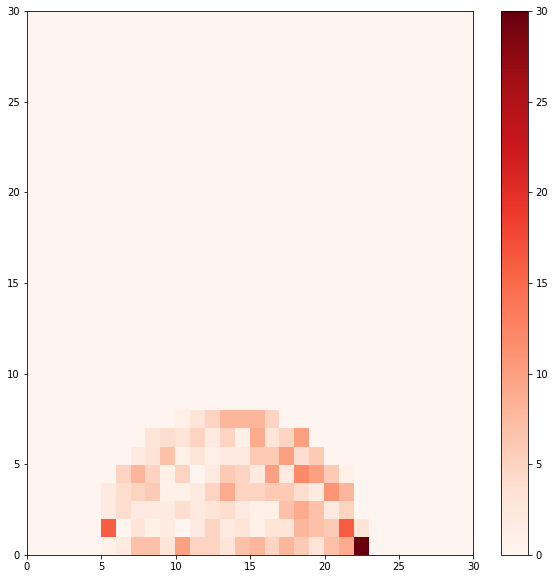

In [10]:
#Rank 1 model
plot_hit_map(best_model)

## Conclusions and Discussions

The best model (in terms of topographic and quantization errors) uses the learning rate of 0.01 and sigma of 2.0. Looking at the remaining models, is noticeable that a smaller sigma with a learning rate of maximum 1.0 is the best choice for training this type of network for this dataset.

Looking at the u-matrix, colors close to red indicates neurons that have a large distance from the other nodes, and colors close to blue indicates neurons that are closer to each other. The best model separates the two classes (cancer or not) in the same area, but the two classes are not completly separated in the space,

Looking at the hitmaps, the best model has a small group of neurons with a lot of hits and the remaining of the network has zero hits, indicating an are to look for.